# Laboratorium 2 - Analiza głównych składowych

## Preprocessing danych

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
def load_images_from_folders(data_folders):
    images = []
    for folder in data_folders:
        folder_path = os.path.join("data", folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)
    return images

In [4]:
def convert_pictures(images):
    for i, img in enumerate(images):
        images[i] = img.convert('L') # konwersja do skali szarości
        images[i] = images[i].resize((224, 224)) # przeskalowanie do wymiarów 224x244x3
        images[i] = np.array(images[i]) # konwersja na format np.array
        images[i] = np.reshape(images[i], -1) # konwersja tablic 2d na wektory

    average_image = np.mean(images,axis=0)

    for i, img in enumerate(images):
        images[i] = images[i] - average_image # centrowanie zbioru

In [5]:
data_folders = ["mold", "mosaic", "septoria"]

In [6]:
images = load_images_from_folders(data_folders)
convert_pictures(images)
X = np.vstack(images)

In [7]:
print("Wymiary tablicy X ->", X.shape)

Wymiary tablicy X -> (60, 50176)


## Analiza głównych składowych

In [8]:
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

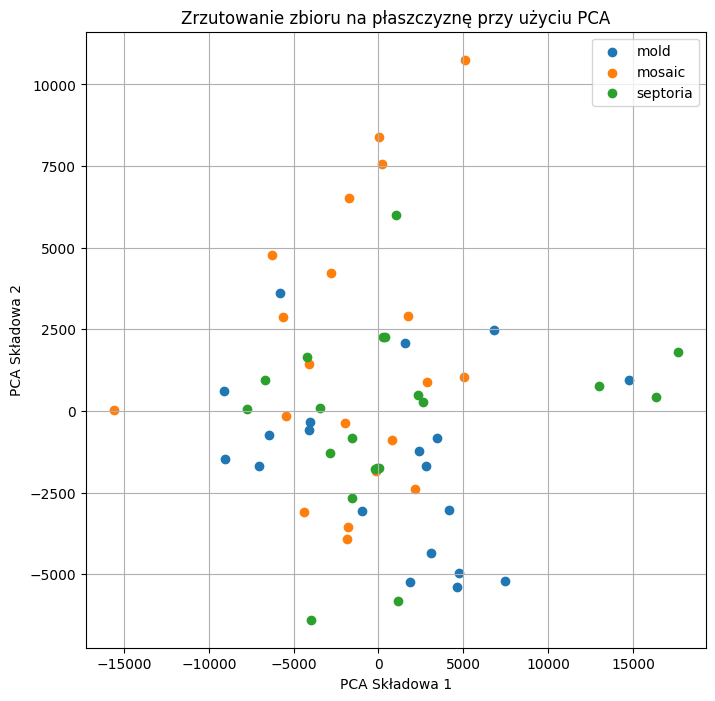

In [9]:
labels = ["mold", "mosaic", "septoria"]
plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    plt.scatter(X_pca[i*20:(i+1)*20, 0], X_pca[i*20:(i+1)*20, 1], label=f'Klasa {label}')


plt.title('Zrzutowanie zbioru na płaszczyznę przy użyciu PCA')
plt.xlabel('PCA Składowa 1')
plt.ylabel('PCA Składowa 2')
plt.legend(labels)
plt.grid(True)
plt.savefig("graphs/pca_2d.png")


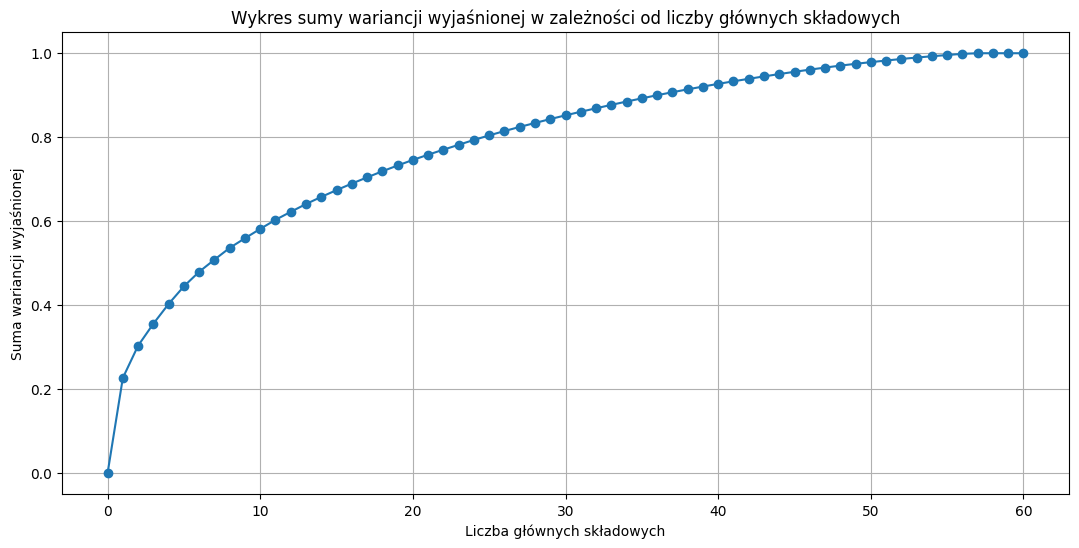

In [10]:
explained_variance_sum = []
for n in range(0, 61):
    explained_variance_sum.append(np.sum(pca.explained_variance_ratio_[:n]))
plt.figure(figsize=(13, 6))
plt.plot(np.arange(0, 61), explained_variance_sum, marker='o', linestyle='-')
plt.title('Wykres sumy wariancji wyjaśnionej w zależności od liczby głównych składowych')
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Suma wariancji wyjaśnionej')
plt.grid(True)
plt.savefig("graphs/var_sum.png")


### Macierz Kowariancji

In [11]:
covariance_matrix_before = np.cov(X.T)

print("Macierz kowariancji przed PCA:")
print(covariance_matrix_before)

covariance_matrix_after = np.cov(X_pca.T)

print("Macierz kowariancji po PCA:")
print(covariance_matrix_after)



Macierz kowariancji przed PCA:
[[4047.56610169 3866.02711864 3663.49152542 ... 1371.11525424
  1503.01016949 1573.49152542]
 [3866.02711864 3951.31186441 3870.40677966 ... 1203.80847458
  1316.57457627 1390.84745763]
 [3663.49152542 3870.40677966 4158.88700565 ... 1142.88983051
  1231.66949153 1301.44632768]
 ...
 [1371.11525424 1203.80847458 1142.88983051 ... 6329.37033898
  6260.9059322  6148.43220339]
 [1503.01016949 1316.57457627 1231.66949153 ... 6260.9059322
  6311.72288136 6248.78813559]
 [1573.49152542 1390.84745763 1301.44632768 ... 6148.43220339
  6248.78813559 6263.1920904 ]]
Macierz kowariancji po PCA:
[[ 3.62698264e+07  1.33190853e-07  3.52491908e-09 ... -4.69478064e-10
  -2.31120572e-10 -2.69772091e-09]
 [ 1.33190853e-07  1.22703876e+07 -6.20455659e-11 ... -2.01584724e-10
  -1.34136807e-09  5.00474925e-10]
 [ 3.52491908e-09 -6.20455659e-11  8.35663076e+06 ... -2.22273668e-10
  -4.49121312e-10  2.87940739e-09]
 ...
 [-4.69478064e-10 -2.01584724e-10 -2.22273668e-10 ...  3.4

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [13]:
print(len(covariance_matrix_before), end = "-> ")
print(len(covariance_matrix_after))

50176-> 60


## Średnie zdjęcie odjęte od pozostałych

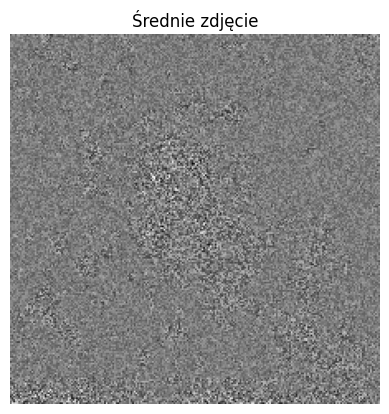

In [14]:
average_image_reshaped = average_image.reshape(224, 224)
plt.imshow(average_image_reshaped, cmap='gray')
plt.axis('off')
plt.title('Średnie zdjęcie')
plt.show()

## Nowe wektory bazowe

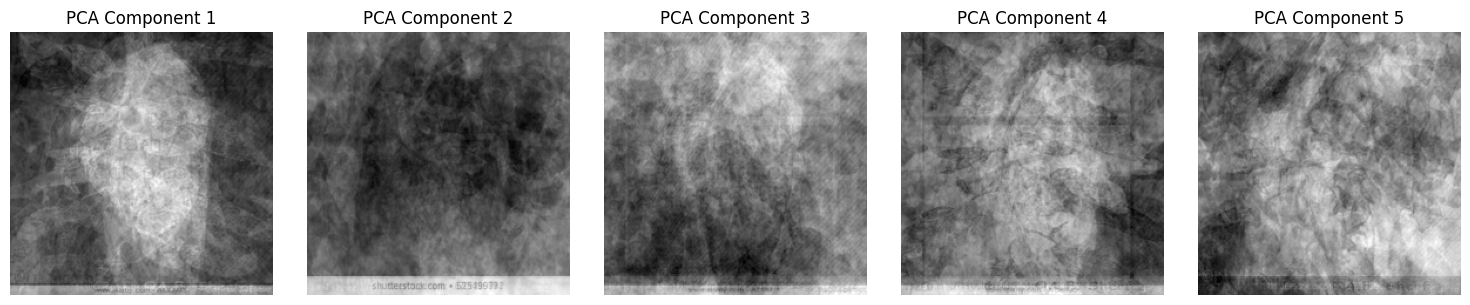

In [17]:
# znalezienie nowych wektorów bazowych

principal_axes = pca.components_
explained_variance = pca.explained_variance_

# Sortowanie według powiązanej wariancji
sorted_indices = np.argsort(explained_variance)[::-1]
principal_axes = principal_axes[sorted_indices]
explained_variance = explained_variance[sorted_indices]

# wizualizacja
num_images= 5

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    ax = axes[i]
    principal_axis_reshaped = principal_axes[i].reshape(224, 224)
    ax.imshow(principal_axis_reshaped, cmap='gray')
    ax.axis('off')
    ax.set_title(f"PCA Component {i+1}")

plt.tight_layout()
plt.show()

## Redukcja wymiarowości obserwacji

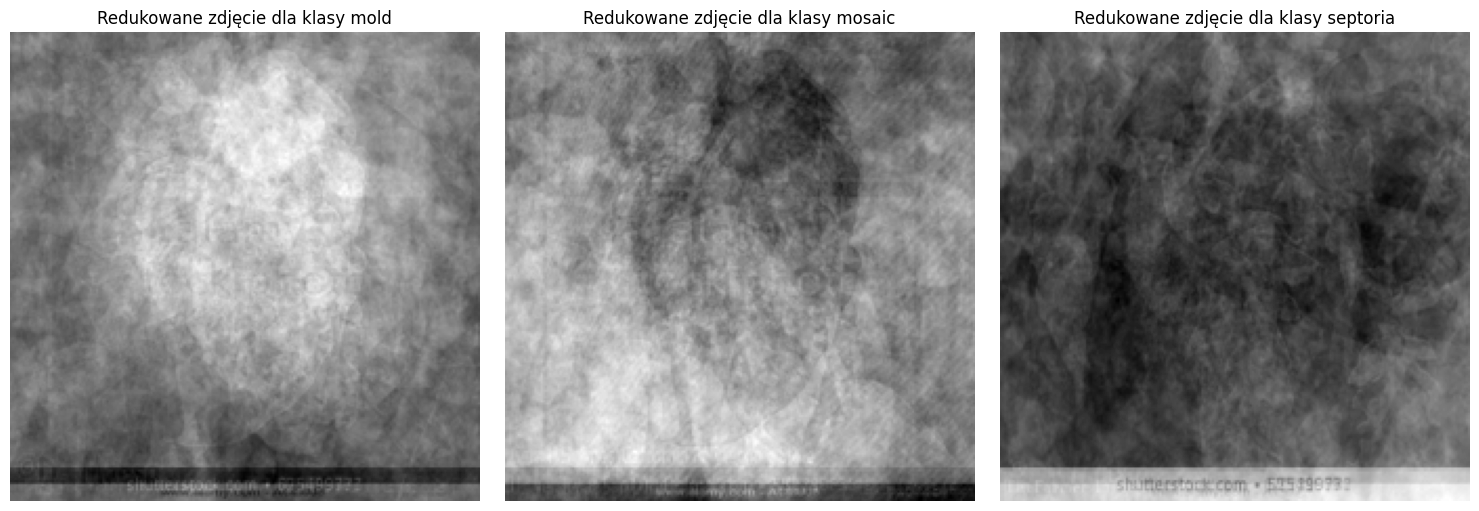

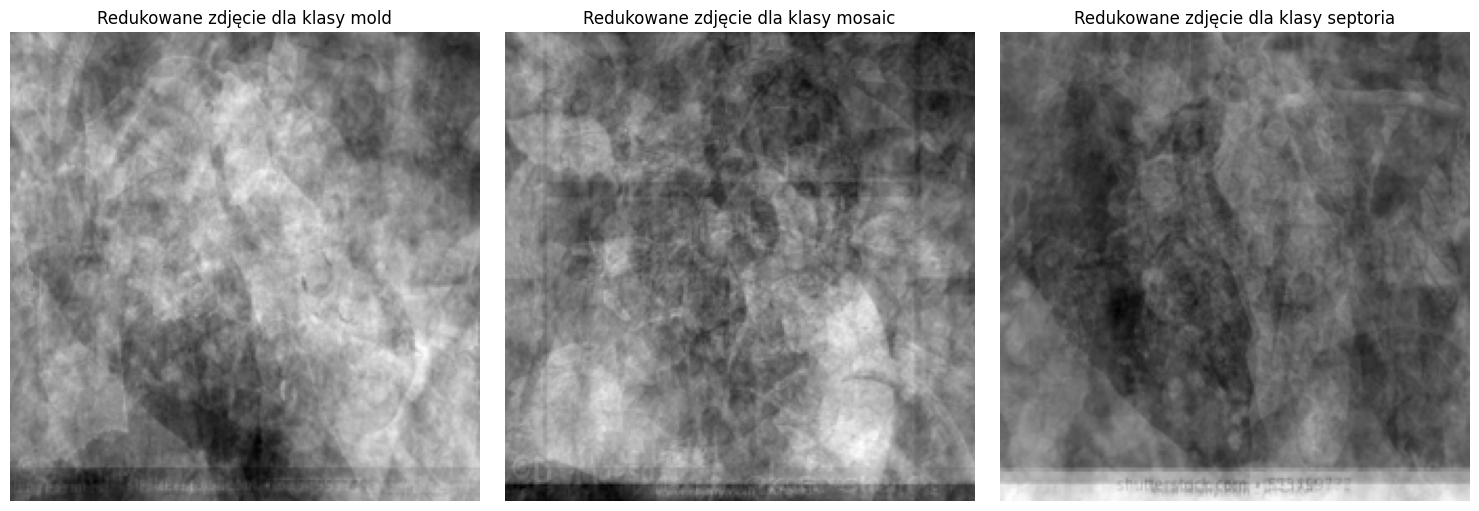

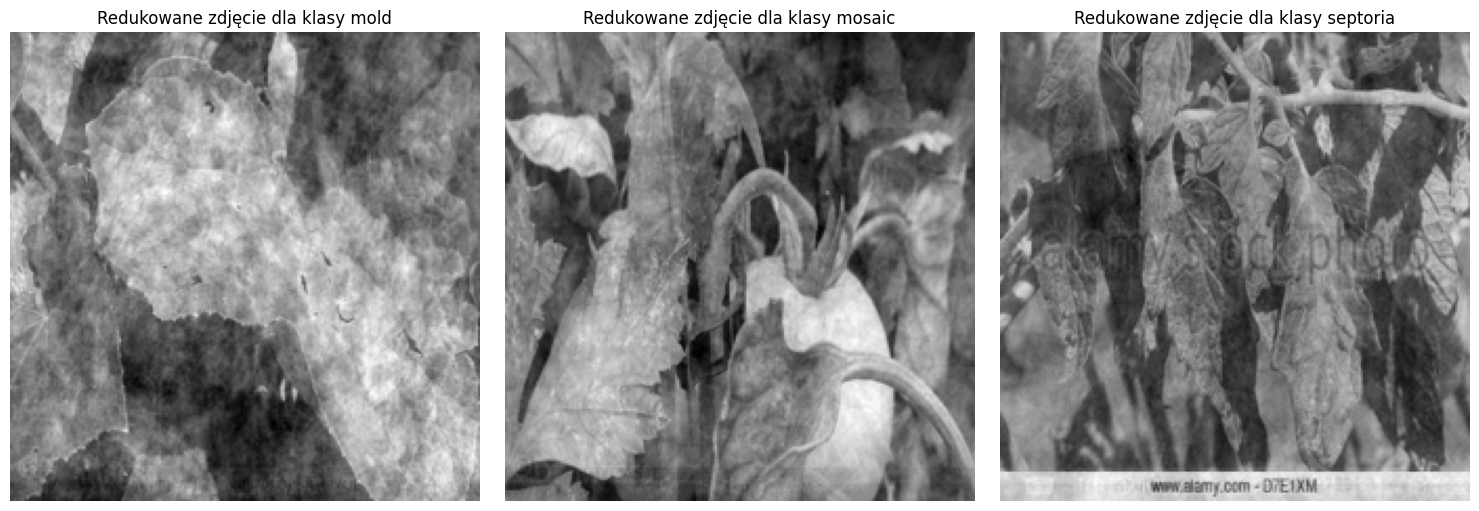

In [35]:
num_components = [3, 9, 27]
i = 0
X_reduced_arr = []

for n in num_components:
    
    # Wybierz n najważniejszych składowych
    pca_components_subset = principal_axes[:n, :]

    # Przeprowadź transformację odwrotną
    X_reduced = np.dot(X_pca[:, :n], pca_components_subset)

    # Dodaj średni wektor
    X_reduced = X_reduced + average_image

    # Przekształć wektory do kształtu zdjęcia i wyświetl
    fig, axes = plt.subplots(1, len(data_folders), figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Odwróć przekształcenie wektor->macierz
        img_reduced = X_reduced[i * 20].reshape(224, 224)

        ax.imshow(img_reduced, cmap='gray')
        ax.set_title(f'Redukowane zdjęcie dla klasy {data_folders[i]}')
        ax.axis('off')
    X_reduced_arr.append(X_reduced)
    plt.tight_layout()
    plt.show()
